In [5]:
# From Melissa Graham notebook

# standard python packages for numerical processing, plotting, and databases
import time
import getpass
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas

# astropy package for time unit conversions
from astropy.time import Time

# lsst packages for data access and display
import lsst.geom
import lsst.afw.display as afwDisplay

# import lsst.daf.butler as dafButler
from lsst.daf.butler import Butler, DatasetType, CollectionType

# lsst packages for executing pipeline tasks
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument

### 1.2. Define functions and parameters

Set a few parameters related to plotting and display.

In [6]:
font = {'size': 14}
matplotlib.rc('font', **font)

pandas.set_option('display.max_rows', 1000)

afwDisplay.setDefaultBackend('matplotlib')

In [4]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

> **Notice:** It is OK to ignore a pink-window message saying "WARNING: version mismatch between CFITSIO header (v4.000999999999999) and linked library (v4.01)."

## 2. Identify the visits to combine

In [5]:
%%time

my_ra_deg = 55.745834
my_dec_deg = -32.269167

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees,
                                       my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_spherePoint, tract

My tract and patch:  4431 17
CPU times: user 3.62 s, sys: 1.3 s, total: 4.91 s
Wall time: 5.08 s


Option to display the deepCoadd image.

(11899.5, 16099.5, 7899.5, 12099.5)

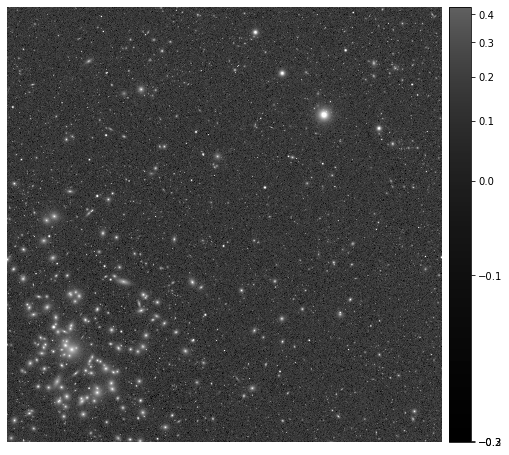

In [7]:
fig = plt.figure(figsize=(12, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image)
plt.gca().axis('off')

### 2.2. Retrieve the deepCoadd's input visits


In [8]:
%%time

my_coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", my_dataId)

CPU times: user 1.88 s, sys: 1.09 s, total: 2.98 s
Wall time: 2.57 s


Option to display the coadd inputs as an astropy table.

In [42]:
#my_coadd_inputs.visits.asAstropy()

The length of this table, 161, indicates that 161 separate visits contributed to this deepCoadd.

In [9]:
len(my_coadd_inputs.visits)

161

Option to list all of the deepCoadd input visit ids.

### 2.3. Identify airmass range for the input visits


In [10]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])

In [11]:
visitTable

visit physical_filter band         ra       decl  skyRotation  \
visitId                                                                    
178142    178142       g_sim_1.4    g  48.816726 -42.998764    55.305716   
180090    180090       g_sim_1.4    g  48.268655 -43.554762    52.942898   
180134    180134       g_sim_1.4    g  49.346433 -43.826917    69.782977   
180135    180135       g_sim_1.4    g  50.037170 -41.679127    62.769883   
183780    183780       g_sim_1.4    g  52.358132 -41.499734   358.191446   
...          ...             ...  ...        ...        ...          ...   
629034    629034       z_sim_1.4    z  70.888982 -26.095592    73.652190   
648610    648610       z_sim_1.4    z  72.150526 -26.008101   335.768899   
691038    691038       z_sim_1.4    z  71.072029 -25.526301    85.644342   
712115    712115       z_sim_1.4    z  70.571841 -25.587608   126.404264   
1207302  1207302       z_sim_1.4    z  71.814876 -25.543604   191.608140   

            azimuth   altitude  zenithDistance   airmass  expTime  \
visitId                                                             
178142   128.492828  65.364165       24.635835  1.097656     30.0   
180090   134.109077  68.495289       21.504711  1.073027     30.0   
180134   143.553058  72.147000       17.853000  1.049297     30.0   
180135   137.300217  73.291392       16.708608  1.043240     30.0   
183780   120.956971  58.011960       31.988040  1.173574     30.0   
...             ...        ...             ...       ...      ...   
629034    95.156511  50.902969       39.097031  1.278896     30.0   
648610    97.548979  45.435132       44.564868  1.386305     30.0   
691038   294.754613  79.703652       10.296348  1.014646     30.0   
712115   265.762347  51.058909       38.941091  1.262612     30.0   
1207302  269.218406  57.512253       32.487747  1.170912     30.0   

                          expMidpt   expMidptMJD                   obsStart  \
visitId                                                                       
178142  2022-08-26 07:54:20.697800  59817.329406 2022-08-26 07:54:05.697800   
180090  2022-08-28 08:05:01.699100  59819.336825 2022-08-28 08:04:46.699100   
180134  2022-08-28 08:35:56.880000  59819.358297 2022-08-28 08:35:41.880000   
180135  2022-08-28 08:36:40.252900  59819.358799 2022-08-28 08:36:25.252900   
183780  2022-09-01 07:01:36.729800  59823.292786 2022-09-01 07:01:21.729800   
...                            ...           ...                        ...   
629034  2024-07-23 10:22:41.971100  60514.432430 2024-07-23 10:22:26.971100   
648610  2024-08-20 08:12:21.216000  60542.341912 2024-08-20 08:12:06.216000   
691038  2024-10-18 08:19:43.324900  60601.347029 2024-10-18 08:19:28.324900   
712115  2024-11-16 08:37:58.963100  60630.359710 2024-11-16 08:37:43.963100   
1207302 2026-11-13 08:26:44.265800  61357.351901 2026-11-13 08:26:29.265800   

          obsStartMJD  
visitId                
178142   59817.329233  
180090   59819.336652  
180134   59819.358124  
180135   59819.358626  
183780   59823.292613  
...               ...  
629034   60514.432257  
648610   60542.341739  
691038   60601.346856  
712115   60630.359537  
1207302  61357.351728  

[19840 rows x 15 columns]

The fact that the id column for both the my_coadd_inputs.vists table and the visitTable is the visit number (visit id) makes it simple to retrieve the MJDs of our coadd input visits.

In [13]:
#my_coadd_visits_mjds = visitTable.loc[my_coadd_inputs.visits['id']]['expMidptMJD']
my_coadd_visits_airmass = visitTable.loc[my_coadd_inputs.visits['id']]['airmass']

In [31]:
binsize = np.arange(np.min(my_coadd_visits_airmass), np.max(my_coadd_visits_airmass), 0.005)

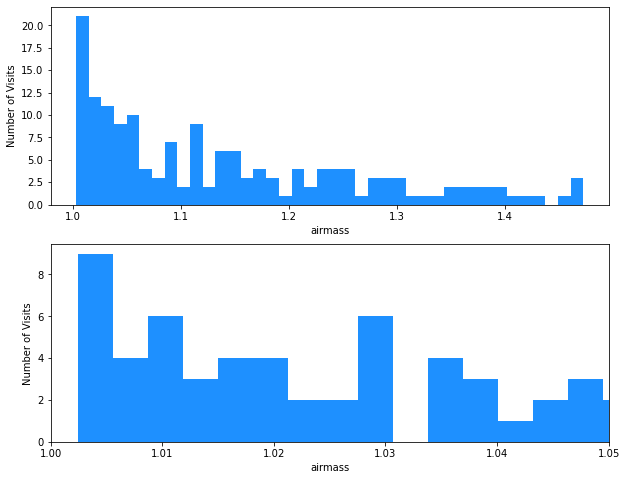

In [45]:
fig, ax = plt.subplots(2, figsize=(10, 8))

ax[0].hist(my_coadd_visits_airmass, bins=40, color='dodgerblue')
ax[0].set_xlabel('airmass')
ax[0].set_ylabel('Number of Visits')

ax[1].hist(my_coadd_visits_airmass, bins=150, color='dodgerblue')
ax[1].set_xlim(1.0,1.05)
ax[1].set_xlabel('airmass')
ax[1].set_ylabel('Number of Visits')
plt.show()

### 2.4. Identify input visits to combine into a new Coadd

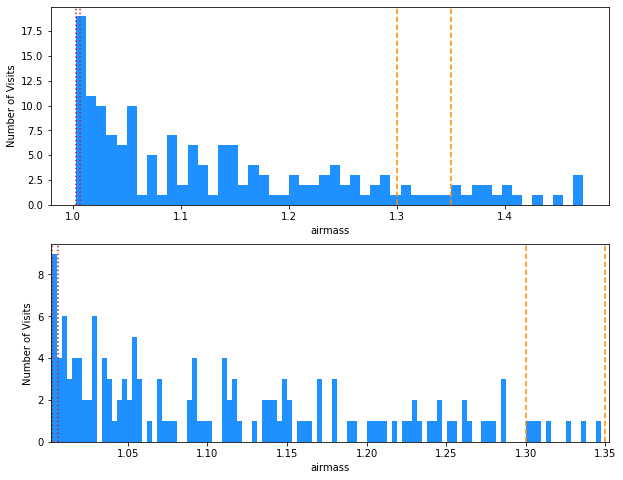

In [48]:
min_airmass = np.min(my_coadd_visits_airmass)

Window1_start = min_airmass
Window1_end = 1.006

Window2_start = 1.3
Window2_end = 1.35

fig, ax = plt.subplots(2, figsize=(10, 8))

ax[0].hist(my_coadd_visits_airmass, bins=50, color='dodgerblue')
ax[0].set_xlabel('airmass')
ax[0].set_ylabel('Number of Visits')
ax[0].axvline(Window1_start, ls='dotted', color='firebrick')
ax[0].axvline(Window1_end, ls='dotted', color='firebrick')
ax[0].axvline(Window2_start, ls='dashed', color='darkorange')
ax[0].axvline(Window2_end, ls='dashed', color='darkorange')

ax[1].hist(my_coadd_visits_airmass, bins=150, color='dodgerblue')
ax[1].set_xlabel('airmass')
ax[1].set_ylabel('Number of Visits')
ax[1].set_xlim([Window1_start-0.001, Window2_end + 0.002])
ax[1].axvline(Window1_start, ls='dotted', color='firebrick')
ax[1].axvline(Window1_end, ls='dotted', color='firebrick')
#ax[1].text(Window1_start+1, 7.5, 'Window1', color='firebrick')
ax[1].axvline(Window2_start, ls='dashed', color='darkorange')
ax[1].axvline(Window2_end, ls='dashed', color='darkorange')
#ax[1].text(Window2_start+1, 7.5, 'Window1', color='darkorange')

plt.show()

## 3. Create a coadd for the visits in Window1

Put the list of visits for Window1 into a string, formatted as a tuple, for use in a query later on.
("Formatted as a tuple" means within round brackets and separated by commas).

In [49]:
my_range = np.array((my_coadd_visits_airmass > Window1_start) & 
                    (my_coadd_visits_airmass < Window1_end))
my_visits = my_coadd_inputs.visits[my_range]
my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)

(192350,256348,256393,713248,1173799,1205981,1209139,1209192)


In [57]:
!butler query-collections dp02 --chains=tree u/alrakomala/*







                              Name                                   Type   
---------------------------------------------------------------- -----------
u/alrakomala/coadd_recreation_nb                                 CHAINED    
  u/alrakomala/coadd_recreation_nb/airmassTestWindow1            RUN        
  2.2i/runs/DP0.2                                                CHAINED    
    2.2i/runs/DP0.2/w_2022_22/PREOPS-1209/20220601T202430Z       RUN        
    2.2i/runs/DP0.2/w_2022_22/PREOPS-1209/20220602T165151Z       RUN        
    2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step7/20220501T161443Z    RUN        
    2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step6_1/20220512T201515Z  RUN        
    2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step6_10/20220514T021220Z RUN        
    2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step6_11/20220514T051259Z RUN        
    2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step6_12/20220514T081014Z RUN        
    2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step6_13/20220514T110509Z RUN  

### 3.1. Name a new butler collection for your output

> **Important:** Use the convention `u/[Your User Name]/coadd_recreation_nb` to set up a new output collection for this tutorial.
Recall that RSP user names are the same as GitHub user names, because GitHub accounts are used to authorize access to the RSP.

In [51]:
my_username = getpass.getuser()
my_outputCollection = 'u/'+my_username+'/coadd_recreation_nb'
#my_outputCollection = 'u/'+my_username+'/output_testKA'
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/alrakomala/coadd_recreation_nb


Check if this output collection already exists? If nothing is printed below this cell, the output collection does not already exist.

In [52]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

u/alrakomala/coadd_recreation_nb
u/alrakomala/coadd_recreation_nb/TestWindow1


Delete the current butler. In the next section, a simple butler is created and used thereafter.

In [54]:
del butler

### 3.2. Set up a simple butler and name the output run for Window1

> **Notice:** In future updates to the LSST Science Pipelines, it will be possible to use: <br>
`simpleButler = SimplePipelineExecutor.prep_butler(config, inputs=[collection], output=my_outputCollection)`

For the LSST Science Pipelines version Weekly_2022_22, the following workaround is needed to set up a simple butler and create a new output collection with the name selected above.

Users have the option of defining the name of the `outputRun` to be whatever they want.

For example, to name an `outputRun` using a unique timestamp, use: <br>
`outputRun = f"{my_outputCollection}/{Instrument.makeCollectionTimestamp()}"` <br>
Timestamps are year month day T hour minute second Z, where the time is UTC.

But in this case, we will just use `TestWindow1` as our `outputRun` name.

In [55]:
#outputRun = f"{my_outputCollection}/TestWindow1"
outputRun = f"{my_outputCollection}/airmassTestWindow1"

tmpButler = Butler(config, writeable=True)

tmpButler.registry.registerCollection(outputRun, CollectionType.RUN)
print('Made CollectionType.RUN: ', outputRun)

tmpButler.registry.registerCollection(my_outputCollection, CollectionType.CHAINED)
print('Made CollectionType.CHAINED: ', my_outputCollection)

collections = [collection]
collections.insert(0, outputRun)

tmpButler.registry.setCollectionChain(my_outputCollection, collections)

simpleButler = Butler(butler=tmpButler, collections=[my_outputCollection], run=outputRun)

del tmpButler

Made CollectionType.RUN:  u/alrakomala/coadd_recreation_nb/airmassTestWindow1
Made CollectionType.CHAINED:  u/alrakomala/coadd_recreation_nb


Check that the subdirectory of the newly created output collection is first in the list.
The output will go into that specific RUN collection.

In [56]:
simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/alrakomala/coadd_recreation_nb/airmassTestWindow1', '2.2i/runs/DP0.2'))

Option: check the output collection run names that currently exist.

In [58]:
for c in sorted(simpleButler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print('Found: ', c)

Found:  u/alrakomala/coadd_recreation_nb
Found:  u/alrakomala/coadd_recreation_nb/TestWindow1
Found:  u/alrakomala/coadd_recreation_nb/airmassTestWindow1


### 3.3. Select the makeWarp and assembleCoadd tasks

In [59]:
assembleCoaddPipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp,assembleCoadd')

### 3.4. Configure the pipeline

Configurations can be set using `addConfigOverride(<taskName>, <configName>, <configValue>)`.

There is only one configuration that must be set, and it is to clarify to the pipeline that it _does not_ need to redo a final image characterization step.
Currently, this configuration is needed due to a version mismatch: the DP0.2 data sets were processed with Version 23 of the LSST Science Pipelines, whereas this notebook uses the version "Weekly 2022_22".
This configuration might not be needed in the future.

In [60]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

### 3.5. Create the full query string

Above, the visits to be recombined were stored in "my_visits_tupleString".

Below, the full query string is built to include the patch being recreated.

In [61]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4431 AND patch = 17 AND visit in (192350,256348,256393,713248,1173799,1205981,1209139,1209192) AND skymap = 'DC2'


### 3.6. Use the Simple Pipeline Executor to run the pipeline


In [62]:
%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

CPU times: user 1.39 s, sys: 151 ms, total: 1.54 s
Wall time: 1min 58s


Run the pipeline.

There will be a lot of standard output. Right-click to the left of the cell and choose "Enable Scrolling for Outputs" to condense all of the output into a scrollable inset window.

This takes about 16 minutes for 6 visits.

In [63]:
%%time
quanta = spe.run()

CPU times: user 17min 49s, sys: 1min 39s, total: 19min 28s
Wall time: 19min 14s


## 4. Display and analyse the results

### 4.1. The quanta

The "quanta" that was just created is a list of objects corresponding to each of the pipeline tasks that were ran.
There will be one for each visit’s makeWarp and one for assembleCoadd.
Each of those has information about, e.g., the name of the task, the reference to the input and output.

In [64]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
1 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
2 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
3 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
4 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
5 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
6 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
7 lsst.pipe.tasks.makeCoaddTempExp.MakeWarpTask
8 lsst.pipe.tasks.assembleCoadd.CompareWarpAssembleCoaddTask


Set `coadd_index` equal to the index for the outputs of `lsst.pipe.tasks.assembleCoadd`.

When this tutorial was prepared, the output of the cell above showed that the first six elements of quanta (indices 0 through 5) were the results of makeWarp for the six visits, and then the seventh (index 6) was the results of `assembleCoadd`.

This should be the same unless you've changed how many visits are input to the custom coadd.

> E.g., `coadd_index = 6`

In [65]:
coadd_index = 8 # 6

Option to display information using the `inputs` and `outputs` methods for quanta.

In [33]:
# quanta[coadd_index].inputs

In [ ]:
# quanta[coadd_index].outputs

In [66]:
for output in quanta[coadd_index].outputs:
    print(output)

DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords)
DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap)
DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, PropertySet)


The deepCoadd is the output we're interested in. Notice that it has a DatasetType of ExposureF, so it is the image.

In [67]:
quanta[coadd_index].outputs['deepCoadd']

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'DC2', tract: 4431, patch: 17})]

From the square brackets, it's a list of just one element. So the DatasetRef for just our new coadd would be:

> `quanta[coadd_index].outputs['deepCoadd'][0]`

The above output is used in Section 4.2.1, below, to retrieve the new custom coadd image from the simpleButler.

### 4.2. The new Coadd

#### 4.2.1. Option 1 - use the quanta

In [36]:
#my_new_deepCoadd = simpleButler.get(quanta[coadd_index].outputs['deepCoadd'][0])

#### 4.2.2. Option 2 - use the dataId

The dataId for the deepCoadd of interest was already defined:
> `my_dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}`

Use it to retrieve the newly made Coadd (which is named deepCoadd by default) from the simple butler.

So long as you use the simpleButler, it will search the collections in order, and since we made sure that the new collection we just created and wrote to appears first -- as checked in the first cell below -- it will take the deepCoadd from that new collection.

In [68]:
simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/alrakomala/coadd_recreation_nb/airmassTestWindow1', '2.2i/runs/DP0.2'))

In [69]:
my_new_deepCoadd = simpleButler.get('deepCoadd', dataId=my_dataId)

<br>

**A note on accessing your run results in another notebook.**

The results have been permanently written to the butler.

If you instantiated a new butler in a new notebook: <br>
`config = "dp02"`<br>
`collection = "u/melissagraham/coadd_recreation_nb/TestWindow1"`<br>
`butler = Butler(config, collections=collection)`<br>

Then you would be able to define the dataId in the same way:<br>
`my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}`<br>

And retrieve your new deepCoadd with:<br>
`my_new_deepCoadd = Butler.get('deepCoadd', dataId=my_dataId)`.

In the two code cells above, since we already have our collection in the `simpleButler`, we use it, but it's not the only way.

#### 4.2.3. Check the inputs of the new Coadd

Check the inputs of my_new_deepCoadd, and compare them with the "queryString", and see that they match.

In [70]:
my_new_deepCoadd_inputs = simpleButler.get("deepCoadd.coaddInputs", my_dataId)

In [76]:
#my_new_deepCoadd_inputs.visits.asAstropy()

(11899.5, 16099.5, 7899.5, 12099.5)

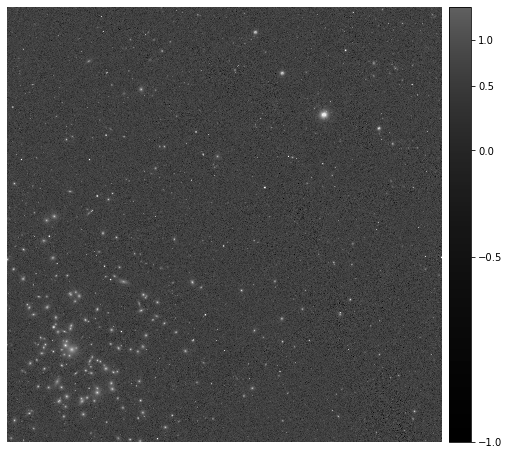

In [77]:
fig = plt.figure(figsize=(12, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_new_deepCoadd.image)
plt.gca().axis('off')

#### 4.2.4. Display the new Coadd

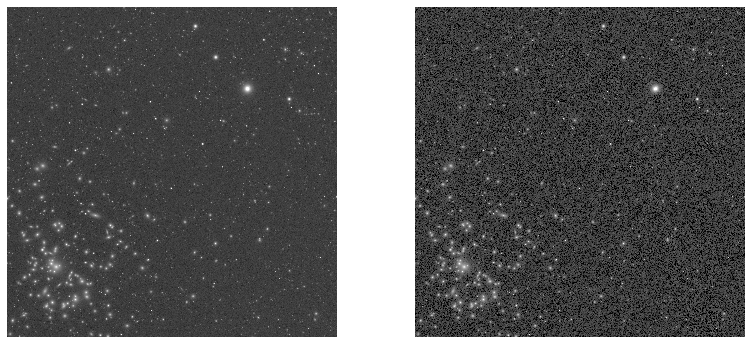

In [7]:
config1 = 'dp02'
collection1 = '2.2i/runs/DP0.2'
butler1 = Butler(config1, collections=collection1)
my_dataId1 = {'band': 'i', 'tract': 4431, 'patch': 17}

config2 = "dp02"
collection2 = "u/alrakomala/coadd_recreation_nb/airmassTestWindow1"
butler2 = Butler(config2, collections=collection2)
my_dataId2 = {'band': 'i', 'tract': 4431, 'patch': 17}

allVisits_deepCoadd = butler1.get('deepCoadd', dataId=my_dataId1)
bestAirmass_deepCoadd = butler2.get('deepCoadd', dataId=my_dataId2)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.sca(ax[0])  
display1 = afwDisplay.Display(frame=fig) 
display1.scale('asinh', min=-0.3, max=0.5)
#display1.scale('asinh', 'zscale')
display1.mtv(allVisits_deepCoadd.image)
display1.show_colorbar(False)
ax[0].axis('off')

plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.scale('asinh', min=-0.3, max=0.5)
display2.mtv(bestAirmass_deepCoadd.image)
display2.show_colorbar(False)
ax[1].axis('off')
plt.tight_layout()
plt.show()


